## 3.1 Classification with a single-layer perceptron
### 3.1.1 Generation of linearly-separable data

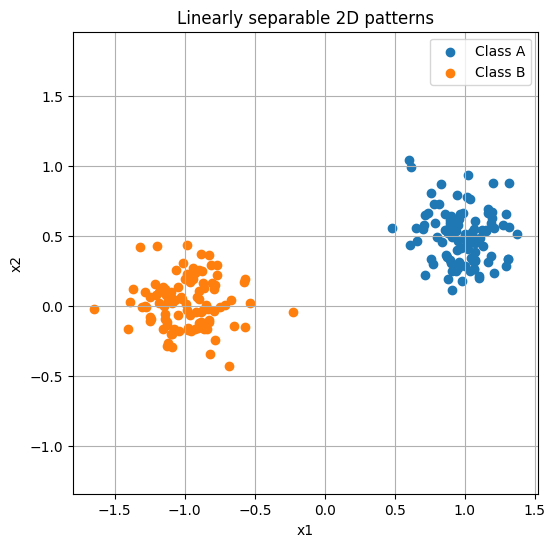

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

# Number of samples per class
n = 100

# Class A parameters
mA = np.array([1.0, 0.5])
sigmaA = 0.2

# Class B parameters
mB = np.array([-1.0, 0.0])
sigmaB = 0.2

# Generate data (independent dimensions, like the MATLAB code)
classA = np.vstack([
    np.random.randn(n) * sigmaA + mA[0],
    np.random.randn(n) * sigmaA + mA[1]
])

classB = np.vstack([
    np.random.randn(n) * sigmaB + mB[0],
    np.random.randn(n) * sigmaB + mB[1]
])

# Stack data and labels
X = np.hstack([classA, classB])           # shape: (2, 2n)
y = np.hstack([np.ones(n), -np.ones(n)])  # labels: +1 for A, -1 for B

# Shuffle samples (important for sequential / online learning)
perm = np.random.permutation(2 * n)
X = X[:, perm]
y = y[perm]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(classA[0], classA[1], c='tab:blue', label='Class A')
plt.scatter(classB[0], classB[1], c='tab:orange', label='Class B')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Linearly separable 2D patterns')
plt.grid(True)
plt.axis('equal')
plt.show()


### 3.1.2 Classification with a single-layer perceptron and analysis

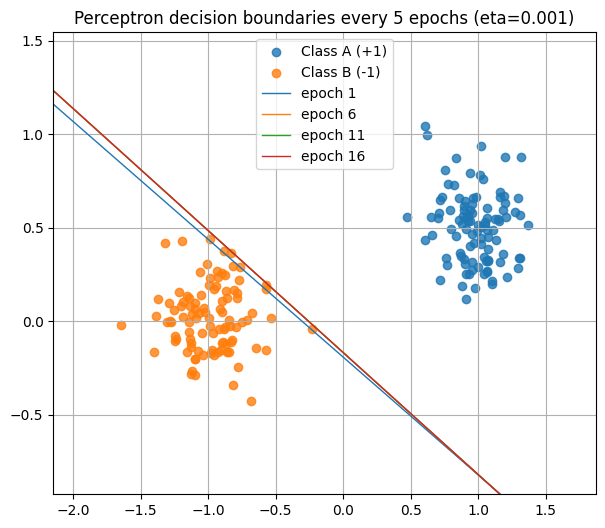

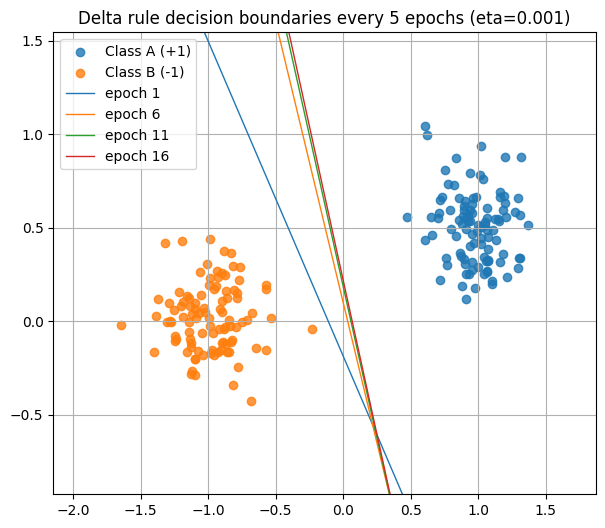

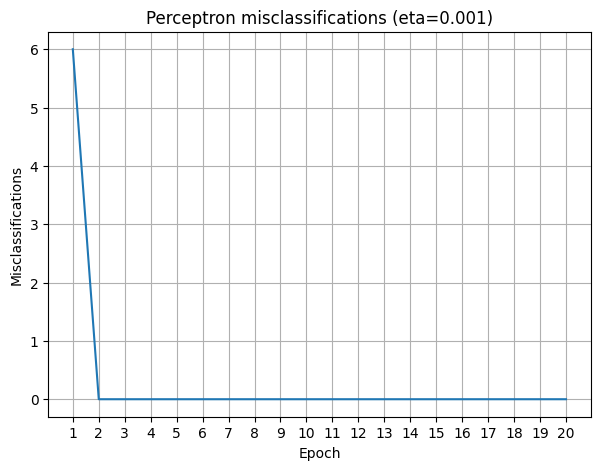

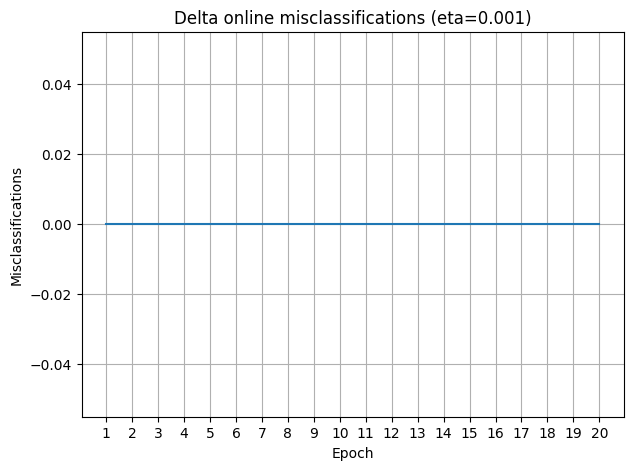

[Perceptron] eta=0.0001 final miscls=0
[Perceptron] eta=0.001 final miscls=0
[Perceptron] eta=0.01 final miscls=0
[Delta online] eta=0.0001 final miscls=0
[Delta online] eta=0.001 final miscls=0
[Delta online] eta=0.01 final miscls=0


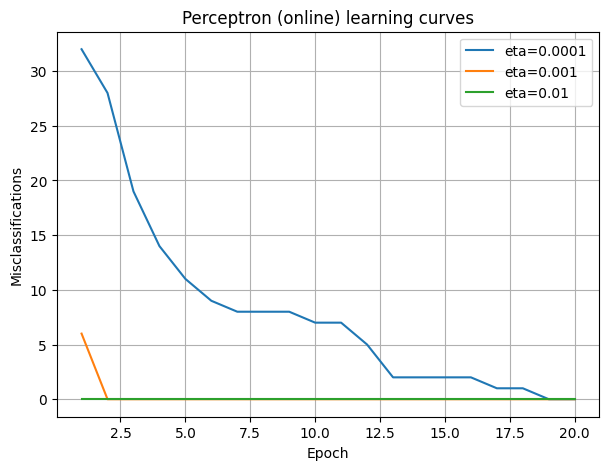

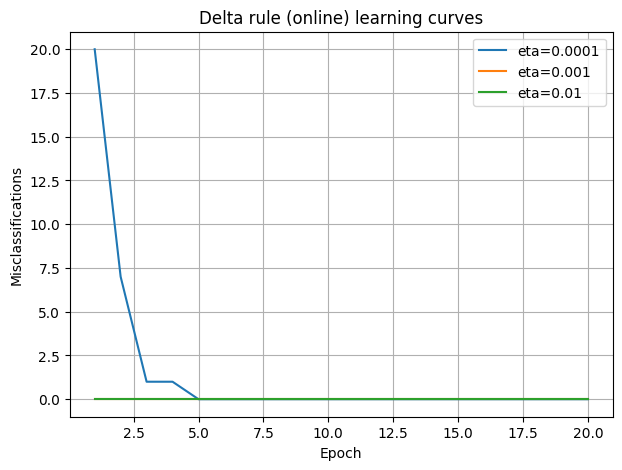

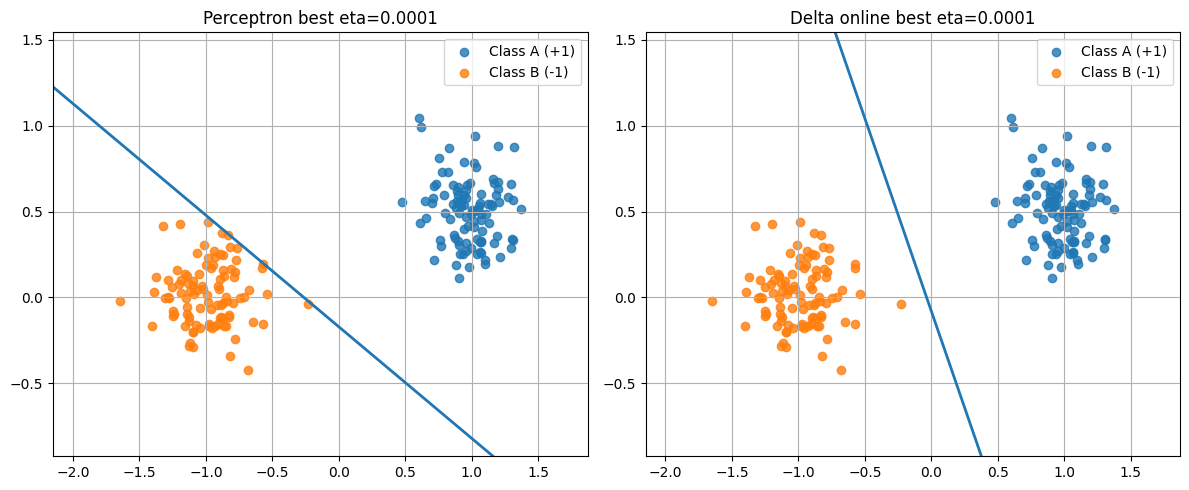

In [16]:
# Reproducibility
np.random.seed(42)

# Number of samples per class
n = 100

# Class A parameters
mA = np.array([1.0, 0.5])
sigmaA = 0.2

# Class B parameters
mB = np.array([-1.0, 0.0])
sigmaB = 0.2

# Generate data (independent dimensions, like the MATLAB code)
classA = np.vstack([
    np.random.randn(n) * sigmaA + mA[0],
    np.random.randn(n) * sigmaA + mA[1]
])

classB = np.vstack([
    np.random.randn(n) * sigmaB + mB[0],
    np.random.randn(n) * sigmaB + mB[1]
])

# Stack data and labels
X = np.hstack([classA, classB])           # shape: (2, 2n)
y = np.hstack([np.ones(n), -np.ones(n)])  # labels: +1 for A, -1 for B

# Shuffle samples (important for sequential / online learning)
perm = np.random.permutation(2 * n)
X = X[:, perm]
y = y[perm]

def add_bias_row(X):
    return np.vstack([X, np.ones((1, X.shape[1]))])  # (3, N)

def predict_bipolar(W, Xb):
    s = W @ Xb
    return np.where(s >= 0, 1.0, -1.0)

def misclassifications(W, Xb, y):
    yhat = predict_bipolar(W, Xb)
    return int(np.sum(yhat != y))

def fixed_axis_limits(X, pad=0.5):
    xmin, xmax = X[0].min() - pad, X[0].max() + pad
    ymin, ymax = X[1].min() - pad, X[1].max() + pad
    return xmin, xmax, ymin, ymax

def compute_boundary_line(W, xmin, xmax, ymin, ymax, npoints=200):
    """Return (xs, ys) for decision boundary within plot limits."""
    w1, w2, b = W
    xs = np.linspace(xmin, xmax, npoints)

    if abs(w2) < 1e-12:
        # vertical line: w1*x + b = 0 -> x = -b/w1
        if abs(w1) < 1e-12:
            return np.array([]), np.array([])
        x0 = -b / w1
        return np.array([x0, x0]), np.array([ymin, ymax])

    ys = -(w1 * xs + b) / w2
    return xs, ys

# ---------- Online training: Perceptron ----------
def train_perceptron_online(Xb, y, eta=0.01, epochs=50, seed=0, shuffle_each_epoch=True):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))  # (3,)
    N = Xb.shape[1]

    W_history = []
    mis_curve = []

    for ep in range(epochs):
        idx = rng.permutation(N) if shuffle_each_epoch else np.arange(N)

        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            yhat = 1.0 if s >= 0 else -1.0
            if yhat != t:
                W = W + eta * t * x  # update only on mistakes

        W_history.append(W.copy())
        mis_curve.append(misclassifications(W, Xb, y))

    return W, np.array(mis_curve), W_history

# ---------- Online training: Delta rule (LMS) ----------
def train_delta_online(Xb, y, eta=0.001, epochs=50, seed=0, shuffle_each_epoch=True):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))  # (3,)
    N = Xb.shape[1]

    W_history = []
    mis_curve = []

    for ep in range(epochs):
        idx = rng.permutation(N) if shuffle_each_epoch else np.arange(N)

        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x              # linear output (no threshold)
            e = (t - s)            # error
            W = W + eta * e * x    # LMS update

        W_history.append(W.copy())
        mis_curve.append(misclassifications(W, Xb, y))

    return W, np.array(mis_curve), W_history

# ---------- Animation function ----------
def animate_training(X, y, W_history, title_prefix="", pause=0.4, pad=0.5):
    Xb_dummy = add_bias_row(X)  # just for miscls display if needed
    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=pad)

    # Prepare plot
    plt.ion()
    fig, ax = plt.subplots(figsize=(7, 6))

    # Plot data
    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], label="Class A (+1)", alpha=0.8)
    ax.scatter(B[0], B[1], label="Class B (-1)", alpha=0.8)

    # Fix axis scaling (IMPORTANT)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    ax.legend()

    # Decision boundary line object
    line, = ax.plot([], [], linewidth=2)
    title = ax.set_title("")

    for ep, W in enumerate(W_history, start=1):
        xs, ys = compute_boundary_line(W, xmin, xmax, ymin, ymax)
        line.set_data(xs, ys)

        # show misclassifications live
        mis = misclassifications(W, Xb_dummy, y)
        title.set_text(f"{title_prefix} | epoch={ep} | miscls={mis}")

        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(pause)

    plt.ioff()
    plt.show()
    
def plot_boundaries_every_k_epochs(X, y, W_history, k=5, title=""):
    # Fixed axis scaling
    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=0.5)

    plt.figure(figsize=(7, 6))
    ax = plt.gca()

    # Plot data
    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], label="Class A (+1)", alpha=0.8)
    ax.scatter(B[0], B[1], label="Class B (-1)", alpha=0.8)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    # Plot boundary lines every k epochs
    for ep in range(1, len(W_history) + 1, k):
        W = W_history[ep - 1]  # ep is 1-based, list is 0-based
        xs, ys = compute_boundary_line(W, xmin, xmax, ymin, ymax)
        ax.plot(xs, ys, linewidth=1, label=f"epoch {ep}")

    ax.set_title(title)
    ax.legend()
    plt.show()


def plot_learning_curves_with_epoch_grid(curve, title="Learning curve"):
    """
    curve: array of length = epochs
    Makes x-axis ticks 1,2,3,... with grid.
    """
    epochs = len(curve)
    xs = np.arange(1, epochs + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, curve)
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title(title)

    # Tick marks 1,2,3,...,epochs
    plt.xticks(xs)

    # Grid (major grid on these integer ticks)
    plt.grid(True)
    plt.show()


# ============================================================
# RUN: comparisons + plots + optional animations
# ============================================================
def run_part_3_1_2_task1(X, y,
                        perceptron_etas=(0.0001, 0.001, 0.01),
                        delta_etas=(0.0001, 0.001, 0.01),
                        epochs=50,
                        seed=1,
                        animate=True,
                        animation_pause=0.5):

    Xb = add_bias_row(X)
    
    

    # ---- Train Perceptron online for each eta ----
    perc_runs = []
    for eta in perceptron_etas:
        W, curve, Whist = train_perceptron_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        perc_runs.append((eta, W, curve, Whist))
        print(f"[Perceptron] eta={eta} final miscls={curve[-1]}")

    # ---- Train Delta online for each eta ----
    delta_runs = []
    for eta in delta_etas:
        W, curve, Whist = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        delta_runs.append((eta, W, curve, Whist))
        print(f"[Delta online] eta={eta} final miscls={curve[-1]}")

    # ---- Plot learning curves: Perceptron ----
    plt.figure(figsize=(7, 5))
    for eta, W, curve, _ in perc_runs:
        plt.plot(range(1, len(curve) + 1), curve, label=f"eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Perceptron (online) learning curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Plot learning curves: Delta online ----
    plt.figure(figsize=(7, 5))
    for eta, W, curve, _ in delta_runs:
        plt.plot(range(1, len(curve) + 1), curve, label=f"eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Delta rule (online) learning curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Plot final decision boundaries for "best" eta of each (lowest final miscls) ----
    best_perc = min(perc_runs, key=lambda r: r[2][-1])
    best_delta = min(delta_runs, key=lambda r: r[2][-1])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, (name, eta, W) in zip(
        axes,
        [("Perceptron", best_perc[0], best_perc[1]),
         ("Delta online", best_delta[0], best_delta[1])]
    ):
        A = X[:, y == 1]
        B = X[:, y == -1]
        ax.scatter(A[0], A[1], alpha=0.8, label="Class A (+1)")
        ax.scatter(B[0], B[1], alpha=0.8, label="Class B (-1)")

        xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=0.5)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.grid(True)

        xs, ys = compute_boundary_line(W, xmin, xmax, ymin, ymax)
        ax.plot(xs, ys, linewidth=2)
        ax.set_title(f"{name} best eta={eta}")
        ax.legend()

    plt.tight_layout()
    plt.show()

    # ---- Animations (boundary after each epoch) ----
    if animate:
        # animate only ONE run each (otherwise you'll watch many animations)
        eta_p, _, _, Whist_p = best_perc
        animate_training(X, y, Whist_p, title_prefix=f"Perceptron online (eta={eta_p})",
                         pause=animation_pause)

        eta_d, _, _, Whist_d = best_delta
        animate_training(X, y, Whist_d, title_prefix=f"Delta online (eta={eta_d})",
                         pause=animation_pause)
# Add bias row
Xb = add_bias_row(X)

# Train once (choose etas you want)
eta_p = 0.001
eta_d = 0.001
epochs = 20

Wp, perc_curve, perc_hist = train_perceptron_online(Xb, y, eta=eta_p, epochs=epochs, seed=1)
Wd, delta_curve, delta_hist = train_delta_online(Xb, y, eta=eta_d, epochs=epochs, seed=1)

# Plot boundaries at every 5 epochs on the SAME plot (per algorithm)
plot_boundaries_every_k_epochs(
    X, y, perc_hist, k=5,
    title=f"Perceptron decision boundaries every 5 epochs (eta={eta_p})"
)

plot_boundaries_every_k_epochs(
    X, y, delta_hist, k=5,
    title=f"Delta rule decision boundaries every 5 epochs (eta={eta_d})"
)

# Learning curves with epoch grid 1,2,3,... (use only if you want this style)
plot_learning_curves_with_epoch_grid(
    perc_curve, title=f"Perceptron misclassifications (eta={eta_p})"
)

plot_learning_curves_with_epoch_grid(
    delta_curve, title=f"Delta online misclassifications (eta={eta_d})"
)

run_part_3_1_2_task1(X, y, epochs=20, animate=False, animation_pause=0.5)

